#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

#### Random seeds for global minimum

In [2]:
np.random.seed(1)

In [3]:
tf.set_random_seed(3)

#### Constants and parameters

In [4]:
M = 32 #number of messages
k = np.log2(M) #number of classes
n_channel = 1
R = k / n_channel #Bit Rate
Pa = 2 #input power where E[|x|^2] <= Pa

# EbN0 =  #SNR
# ...

EbNo = 10 ** (7/10)
noise_std = np.sqrt(1 / (2 * R * EbNo))
num_taps = 1
reyleigh_std = num_taps / np.sqrt(2)

#### Generating data

In [5]:
#Train data:

N = 100000 #size
data = np.random.randint(M, size = N) #from 0 t0 M-1

In [6]:
data

array([ 5, 11, 12, ..., 16,  0,  2])

#### One-hot vector

In [7]:
data_one = []
for i in data:
    vec = np.zeros(M)
    vec[i] = 1
    data_one.append(vec)
    
data_one = np.array(data_one)

In [8]:
data_one.shape

(100000, 32)

In [9]:
data_one

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [10]:
#Test data:

N_test = 100000
data_test = np.random.randint(M, size = N_test)

data_test_one = []
for i in data_test:
    vec = np.zeros(M)
    vec[i] = 1
    data_test_one.append(vec)
    
data_test_one = np.array(data_test_one)

#### NN and so

In [11]:
#Transmitter NN (encoder)+ Normalization:

from tensorflow.keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as be

input_sig = Input(shape = (M, ))
encoder1 = Dense(M, activation = 'relu')(input_sig)
encoder2 = Dense(2 * n_channel, activation = 'linear')(encoder1) #inphase & quadrature
encoder3 = BatchNormalization()(encoder2)
encoder4 = Lambda(lambda x: Pa / np.sqrt(2) * be.l2_normalize(x, axis = -1))(encoder3)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
#Noisy channel:

channel1 = GaussianNoise(np.sqrt(1 / (2 * R * EbNo)))(encoder4)
# channel1 = GaussianNoise(np.sqrt(1 / (2 * R * EbNo)))(encoder2)

In [13]:
#Receiver NN (decoder):

decoder1 = Dense(M, activation = 'relu')(channel1)
decoder2 = Dense(M, activation = 'softmax')(decoder1) #multi-class
autoencoder = Model(input_sig, decoder2)
adam = Adam(lr = 0.01)
autoencoder.compile(optimizer = adam, loss = 'categorical_crossentropy') #SGD

In [14]:
#The summary of the model:

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
batch_normalization (BatchNo (None, 2)                 8         
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                96    

In [15]:
autoencoder.fit(data_one, data_one, epochs = 50, batch_size = 1024)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 100000 samples
Epoch 1/50
100000/100000 [==============================] - 1s 10us/sample - loss: 1.8175
Epoch 2/50
100000/100000 [==============================] - 0s 5us/sample - loss: 1.0687
Epoch 3/50
100000/100000 [==============================] - 1s 5us/sample - loss: 0.9103
Epoch 4/50
100000/100000 [==============================] - 1s 5us/sample - loss: 0.8655
Epoch 5/50
100000/100000 [==============================] - 1s 5us/sample - loss: 0.8277
Epoch 6/50
100000/100000 [==============================] - 1s 5us/sample - loss: 0.8281
Epoch 7/50
100000/100000 [==============================] - 1s 5us/sample - loss: 0.8157
Epoch 8/50
100000/100000 [==============================] - 1s 6us/sample - loss: 0.8219
Epoch 9/50
100000/100000 [==============================] - 1s 7us/sample - loss: 0.8195
Epoch 10/50
100000/100000 [==============================] - 1s 6us/sample - los

#### Encoder Block

In [16]:
encoder = Model(input_sig, encoder4)
# encoder = Model(input_sig, encoder2)

#### Channel Block

In [17]:
channel_input = Input(shape = (2 * n_channel, ))
channel_output = autoencoder.layers[-3](channel_input)
channel = Model(channel_input, channel_output)

#### Decoder Block

In [18]:
decoder_input = Input(shape = (2 * n_channel, ))
decoder_middle = autoencoder.layers[-2](decoder_input)
decoder_output = autoencoder.layers[-1](decoder_middle)
decoder = Model(decoder_input, decoder_output)

#### Constellation diagram for the transmitted message

In [19]:
scatter_plt_t = []

for i in range(0, M):
    vec = np.zeros(M)
    vec[i] = 1
    scatter_plt_t.append(encoder.predict(vec.reshape((1, vec.shape[0])))) #because of "predict" method constraint #or: np.expand_dims(vec, axis = 0) -> (1, M) 

scatter_plt_t = np.array(scatter_plt_t)

In [20]:
scatter_plt_t

array([[[ 0.69250655,  1.233059  ]],

       [[ 0.1934876 ,  1.4009148 ]],

       [[-0.6436657 ,  1.2592436 ]],

       [[ 1.4109061 ,  0.09666537]],

       [[ 0.43797708,  1.3446845 ]],

       [[-0.6851821 , -1.2371441 ]],

       [[-1.4038299 , -0.17106067]],

       [[ 0.86257935, -1.1206948 ]],

       [[-1.2353865 , -0.6883461 ]],

       [[ 1.071633  , -0.92282325]],

       [[ 1.1256354 ,  0.8561219 ]],

       [[ 0.12496598, -1.4086814 ]],

       [[ 0.9332698 ,  1.0625477 ]],

       [[ 0.39295018, -1.3585249 ]],

       [[-1.2550528 ,  0.65179944]],

       [[-0.9052302 ,  1.0865347 ]],

       [[-1.4094899 ,  0.11549013]],

       [[-1.3357152 , -0.4646128 ]],

       [[ 1.2679628 ,  0.6263149 ]],

       [[-1.1107899 ,  0.8752975 ]],

       [[ 1.3667762 ,  0.36321163]],

       [[-0.10147827,  1.4105681 ]],

       [[-0.3928488 ,  1.3585542 ]],

       [[ 1.340121  , -0.45174736]],

       [[ 1.2253879 , -0.7059918 ]],

       [[-0.40514073, -1.3549395 ]],

       [[-0.

In [21]:
scatter_plt_t.shape # -> (M, 1, 2*n_channel) -> But for plotting we should: (M, 2*n_channel, 1)

(32, 1, 2)

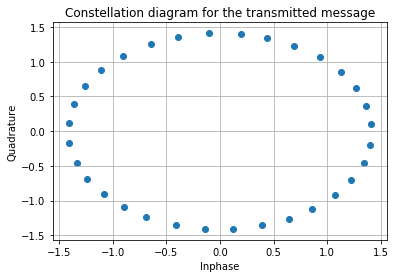

In [22]:
scatter_plt_t = scatter_plt_t.reshape(M, 2*n_channel, 1)
plt.scatter(x = scatter_plt_t[:, 0], y = scatter_plt_t[:, 1])
plt.grid()
plt.title('Constellation diagram for the transmitted message')
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.show()

#### Constellation diagram for the received message

In [23]:
NN_channel_input = Input(shape = (M, ))
NN_channel1 = autoencoder.layers[-7](NN_channel_input)
NN_channel2 = autoencoder.layers[-6](NN_channel1) #inphase & quadrature
NN_channel3 = autoencoder.layers[-5](NN_channel2)
NN_channel4 = autoencoder.layers[-4](NN_channel3)
NN_channel5_output = autoencoder.layers[-3](NN_channel4)
# NN_channel5_output = autoencoder.layers[-3](NN_channel2)
NN_channel = Model(NN_channel_input, NN_channel5_output)

In [24]:
scatter_plt_r = []

for i in range(0, M):
    vec = np.zeros(M)
    vec[i] = 1 
    scatter_plt_r.append(NN_channel.predict(vec.reshape((1, vec.shape[0])))) #because of "predict" method constraint #or: np.expand_dims(vec, axis = 0) -> (1, M) 

scatter_plt_r = np.array(scatter_plt_r)

In [25]:
scatter_plt_r

array([[[ 0.69250655,  1.233059  ]],

       [[ 0.1934876 ,  1.4009148 ]],

       [[-0.6436657 ,  1.2592436 ]],

       [[ 1.4109061 ,  0.09666537]],

       [[ 0.43797708,  1.3446845 ]],

       [[-0.6851821 , -1.2371441 ]],

       [[-1.4038299 , -0.17106067]],

       [[ 0.86257935, -1.1206948 ]],

       [[-1.2353865 , -0.6883461 ]],

       [[ 1.071633  , -0.92282325]],

       [[ 1.1256354 ,  0.8561219 ]],

       [[ 0.12496598, -1.4086814 ]],

       [[ 0.9332698 ,  1.0625477 ]],

       [[ 0.39295018, -1.3585249 ]],

       [[-1.2550528 ,  0.65179944]],

       [[-0.9052302 ,  1.0865347 ]],

       [[-1.4094899 ,  0.11549013]],

       [[-1.3357152 , -0.4646128 ]],

       [[ 1.2679628 ,  0.6263149 ]],

       [[-1.1107899 ,  0.8752975 ]],

       [[ 1.3667762 ,  0.36321163]],

       [[-0.10147827,  1.4105681 ]],

       [[-0.3928488 ,  1.3585542 ]],

       [[ 1.340121  , -0.45174736]],

       [[ 1.2253879 , -0.7059918 ]],

       [[-0.40514073, -1.3549395 ]],

       [[-0.

In [26]:
scatter_plt_r.shape

(32, 1, 2)

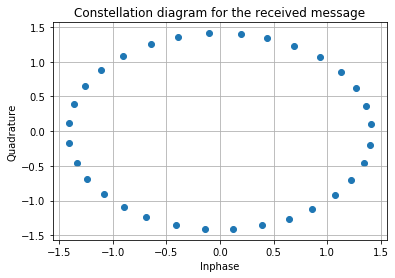

In [27]:
scatter_plt_r = scatter_plt_r.reshape(M, 2*n_channel, 1)
plt.scatter(x = scatter_plt_r[:, 0], y = scatter_plt_r[:, 1])
plt.grid()
plt.title('Constellation diagram for the received message')
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.show()

#### Demodulated message

In [28]:
# autoenc_input = Input(shape = (M, ))
# autoenc1 = autoencoder.layers[-7](autoenc_input)
# autoenc2 = autoencoder.layers[-6](autoenc1) #inphase & quadrature
# autoenc3 = autoencoder.layers[-5](autoenc2)
# autoenc4 = autoencoder.layers[-4](autoenc3)
# autoenc5 = autoencoder.layers[-3](autoenc4)
# # autoenc5 = autoencoder.layers[-3](autoenc2)
# autoenc6 = autoencoder.layers[-2](autoenc5)
# autoenc7 = autoencoder.layers[-1](autoenc6)
# autoenc = Model(autoenc_input, autoenc7)

In [29]:
output_demod = []

data_ex = np.arange(0, M)

for i in data_ex:
    vec = np.zeros(M)
    vec[i] = 1
    output_demod.append(autoencoder.predict(vec.reshape((1, vec.shape[0])))) #because of "predict" method constraint #or: np.expand_dims(vec, axis = 0) -> (1, M) 
    #or: scatter_plt_d.append(autoencoder.predict(vec.reshape((1, vec.shape[0]))))
    
output_demod = np.array(output_demod)
output_demod = np.argmax(output_demod, axis = 0)

In [30]:
output_demod #The demodulated output

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]],
      dtype=int64)

In [31]:
output_demod.shape

(1, 32)

In [32]:
data_ex #The original input (symbols)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [33]:
# #This is the Demodulated message which is similar as the Normalized input message i.e., bellow:
# # bellow = scatter_plt_d

# normalized_input_input = Input(shape = (M, ))
# normalized_input1 = BatchNormalization()(normalized_input_input)
# normalized_input2 = Lambda(lambda x: Pa / np.sqrt(2) * be.l2_normalize(x, axis = -1))(normalized_input1)
# normalized_input= Model(normalized_input_input, normalized_input2)

# symbol_normalized = normalized_input.predict(data_one)

In [34]:
# symbol_normalized

#### BER

In [35]:
snr = list(np.arange(0, 20+1))
ber = list(np.zeros(len(snr))) #or: ber = [None]*len(EbNodB_range

In [36]:
for i in range(0, len(snr)):
    
    EbNo = 10 ** (snr[i] / 10)
    noise_std = np.sqrt(1 / (2 * R * EbNo))
    noise_mean = 0
    count_error = 0
    
    noise = np.random.randn(N, 2 * n_channel) * noise_std
    signal_enc = encoder.predict(data_test_one)
    noisy_signal = signal_enc + noise
    signal_pred = decoder.predict(noisy_signal)
    output_pred = np.argmax(signal_pred, axis=1)
    
    count_error = (output_pred != data_test)
    count_error = count_error.astype(int).sum()
    
    ber[i] = count_error / N
    print('SNR:', snr[i], '    BER:', ber[i])

SNR: 0     BER: 0.66548
SNR: 1     BER: 0.62968
SNR: 2     BER: 0.58818
SNR: 3     BER: 0.54664
SNR: 4     BER: 0.49858
SNR: 5     BER: 0.45098
SNR: 6     BER: 0.39977
SNR: 7     BER: 0.35083
SNR: 8     BER: 0.29902
SNR: 9     BER: 0.25271
SNR: 10     BER: 0.20744
SNR: 11     BER: 0.16677
SNR: 12     BER: 0.13065
SNR: 13     BER: 0.10031
SNR: 14     BER: 0.07522
SNR: 15     BER: 0.05661
SNR: 16     BER: 0.04111
SNR: 17     BER: 0.02898
SNR: 18     BER: 0.02089
SNR: 19     BER: 0.01337
SNR: 20     BER: 0.00848


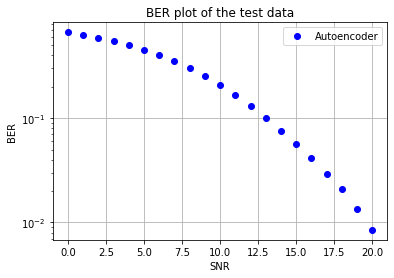

In [43]:
plt.plot(snr, ber, 'bo', label='Autoencoder')
plt.grid()
plt.title('BER plot of the test data')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('BER') 
plt.legend(loc = 'upper right', ncol = 1)
plt.show()